# 📊 Proyecto de Machine Learning - Metodología CRISP-DM

## 🏦 Análisis de Datos Bancarios

**Objetivo:** Desarrollar modelos predictivos para el comportamiento de clientes bancarios.

**Metodología:** CRISP-DM (Cross Industry Standard Process for Data Mining)

---

### 📋 Fases del Proyecto:
1. **Entendimiento del Negocio** - Definir objetivos y variables
2. **Comprensión de los Datos** - Análisis exploratorio estadístico
3. **Preparación de Datos** - Limpieza y tratamiento de valores faltantes
4. **Transformación de Datos** - Encoding y escalamiento
5. **Análisis de Correlación** - Matriz de correlación y duplicados
6. **Técnicas de Regularización** - Ridge y Lasso
7. **Métricas de Evaluación** - MSE y R²

# 1. Entendimiento del Negocio

##  Contexto
- **Problema:** El banco necesita identificar qué clientes son activos en el uso de sus tarjetas y predecir el nivel de endeudamiento en la línea de crédito. Esto permitirá optimizar campañas de retención y asignación de cupos de crédito.
- **Campos del dataset:** Variables demográficas (`Edad`, `Sexo`, `Region`, `Renta`, `Antiguedad`), de productos (`Ctacte`, `Debito`, `Consumo`, `Hipotecario`, `Internauta`, `Adicional`), de cupos (`CUPO_L1`, `CUPO_MX`, `CUPO_L2`) y de comportamiento transaccional (`Fac*`, `Txs*`, `FlgAct*`, `Pago*`, `UsoL*`).
- **Alcance:** Construir modelos de Machine Learning que permitan tanto clasificar clientes activos vs. inactivos, como estimar el monto de uso de la línea de crédito.

---

##  Objetivos
- **Variable a predecir (Regresión):** `UsoL1_T12` → Monto de deuda en la línea de compras de la tarjeta de crédito en el mes X.  
- **Variable a predecir (Clasificación):** `Cliente_Activo` (derivada de `FlgAct_T12 > 0`) → Indicador de actividad del cliente en el mes X.

---

##  Criterios de Éxito
- **Regresión:**
  - R² > 0.7 (el modelo explica al menos el 70% de la variabilidad).
  - MSE minimizado para reducir error promedio.  
- **Clasificación:**
  - Accuracy > 80%.  
  - Precision y Recall balanceados (evitar falsos positivos y negativos en exceso).  

---

## Hipótesis
1. Los clientes con **mayor renta y cupo (`Renta`, `CUPO_L1`)** presentan mayor nivel de endeudamiento (`UsoL1_T12`).  
2. Los clientes con **más productos asociados** (`Ctacte`, `Debito`, `Hipotecario`) son más propensos a ser **clientes activos**.  
3. La **antigüedad del cliente** influye en la probabilidad de mantener un uso sostenido de la tarjeta.  
4. Variables de comportamiento (`Txs*`, `Fac*`, `FlgAct*`) tienen mayor correlación con la actividad que variables demográficas.  


In [8]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette("husl")

print("✅ Librerías importadas exitosamente!")

✅ Librerías importadas exitosamente!


In [9]:
# Paso 2: Cargar los datos
df = pd.read_csv('archivo_convertido.csv')
print("Dataset cargado exitosamente!")
print(f"Dimensiones: {df.shape}")
df.head()

Dataset cargado exitosamente!
Dimensiones: (51125, 575)


,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,...,1.565,1.566,1.567,1.568,1.569,1.570,1.571,1.572,1.573,574
0,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,...,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target,NaN
1,1,160,M,13,43,NaN,130,1,1,0,...,33000,0,1099866,0,1099866,15080,0,R,0,NaN
2,2,160,H,13,46,143640,69,1,0,0,...,300000,0,214592,0,214592,83596,0,R,0,NaN
3,3,170,H,13,45,929106,24,1,1,0,...,216676,0,0,0,7400,0,0,T,0,NaN
4,4,151,H,13,46,172447,134,0,1,0,...,60000,0,272762,0,272762,10591,0,R,0,NaN


# 2. Comprensión de los Datos

## Análisis estadístico y visualización

### Objetivos de esta fase:
- **Variables numéricas:** Medidas de tendencia central, distribución (histogramas)
- **Variables categóricas:** Moda, distribución (gráficos de barras y torta)
- **Valores faltantes:** Identificación y cuantificación
- **🔍 IMPORTANTE:** Interpretaciones, observaciones y hallazgos de cada análisis

📊 INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51125 entries, 0 to 51124
Columns: 575 entries, 1 to 574
dtypes: float64(1), object(574)
memory usage: 224.3+ MB
None

📊 ESTADÍSTICAS NUMÉRICAS
     count  mean  std  min  25%  50%  75%  max
574    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN

📋 ESTADÍSTICAS CATEGÓRICAS
        count   unique       top     freq
1       51125    51125        Id        1
1.1     51125       25       170    15798
1.2     51124        3         H    27410
1.3   51072.0     27.0      13.0  32292.0
1.4     51125      108        27     2568
1.5   37760.0  33914.0  400000.0    235.0
1.6     51125      376        10     1652
1.7     51125        5         1    34374
1.8     51125        5         0    37335
1.9     51125        5         0    31051
1.10    51125        5         0    46956
1.11    51125        5         1    46380
1.12    51125        5         0    50057
1.13    51125        5         0    43264
1.14    51125       

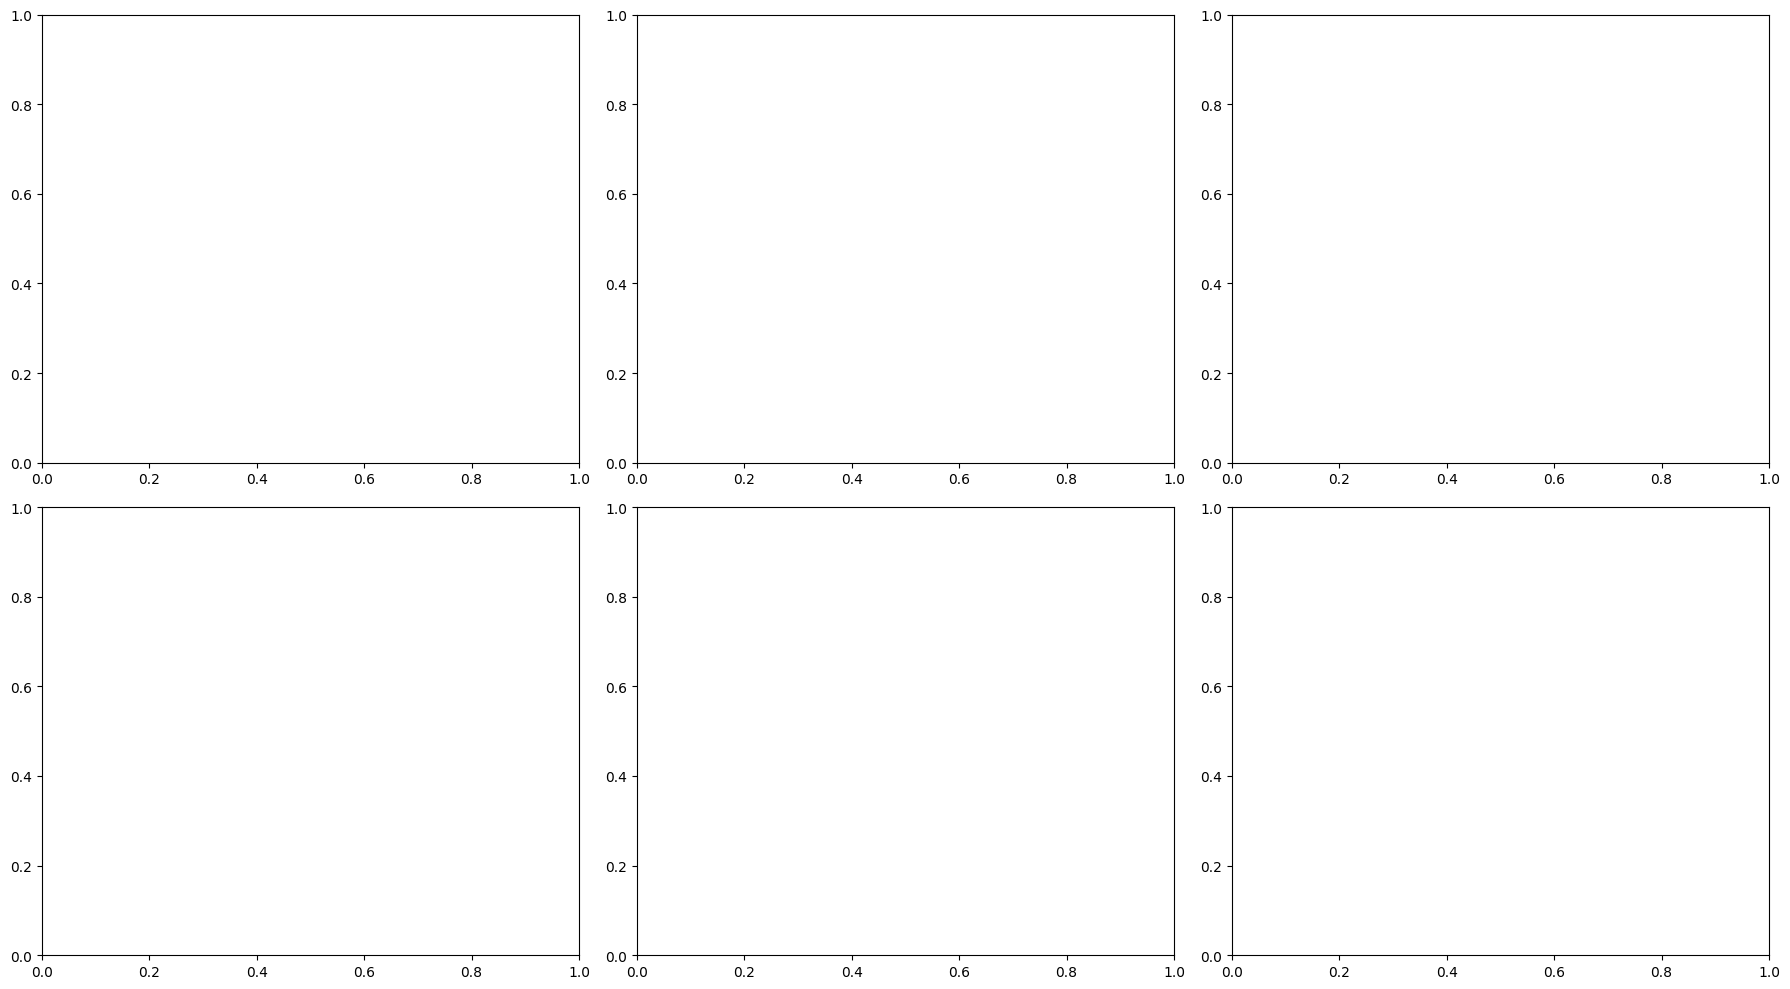


🔍 INTERPRETACIONES Y HALLAZGOS PRINCIPALES

📋 OBSERVACIONES GENERALES:
   • Dataset con 51125 registros y 575 variables
   • 1 numéricas, 574 categóricas
   • Variables con valores faltantes: 511


In [11]:
# Paso 3: Análisis estadístico básico
# ==================================================
# 🔎 ANÁLISIS EXPLORATORIO EFICIENTE
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear muestra (para evitar lentitud con todo el dataset)
sample_df = df.sample(n=5000, random_state=42)

print("="*50)
print("📊 INFORMACIÓN GENERAL DEL DATASET")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("📊 ESTADÍSTICAS NUMÉRICAS")
print("="*50)
print(df.describe().T.head(15))  # primeras 15 por tamaño

print("\n" + "="*50)
print("📋 ESTADÍSTICAS CATEGÓRICAS")
print("="*50)
print(df.describe(include=['object', 'category']).T.head(15))  # primeras 15

# ==================================================
# Identificar tipos de variables
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📊 Variables numéricas: {len(numeric_cols)}")
print(f"📋 Variables categóricas: {len(categorical_cols)}")

# ==================================================
# 🔍 Análisis de valores faltantes
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Valores_Faltantes': missing_data.values,
    'Porcentaje': missing_percent.values
}).sort_values('Porcentaje', ascending=False)

print("\n" + "="*50)
print("📉 VARIABLES CON VALORES FALTANTES")
print("="*50)
print(missing_df[missing_df['Valores_Faltantes'] > 0].head(20))

# ==================================================
# 📈 Distribuciones - Numéricas (muestra)
key_numeric_vars = ['Renta','Edad','Antiguedad','CUPO_L1','UsoL1_T12','FacDebAtm_T12']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(key_numeric_vars):
    if col in sample_df.columns:
        axes[i].hist(sample_df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribución {col}')
        mean_val = sample_df[col].mean()
        median_val = sample_df[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
        axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

# ==================================================
# 📋 Distribuciones - Categóricas (muestra)
key_categorical_vars = ['Sexo','Region','Dualidad']

for col in key_categorical_vars:
    if col in sample_df.columns:
        plt.figure(figsize=(8,5))
        sample_df[col].value_counts().head(10).plot(kind='bar', color='salmon')
        plt.title(f'Distribución {col} (Top 10)')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.show()

# ==================================================
# INTERPRETACIONES Y HALLAZGOS
print("\n" + "="*80)
print("🔍 INTERPRETACIONES Y HALLAZGOS PRINCIPALES")
print("="*80)

# Variable objetivo - Regresión
if 'UsoL1_T12' in df.columns:
    uso_stats = df['UsoL1_T12'].describe()
    print(f"📈 VARIABLE OBJETIVO (Regresión) - UsoL1_T12:")
    print(f"   • Rango: {uso_stats['min']:.2f} a {uso_stats['max']:.2f}")
    print(f"   • Media: {uso_stats['mean']:.2f}, Mediana: {uso_stats['50%']:.2f}")
    print(f"   • Desviación estándar: {uso_stats['std']:.2f}")

# Variable objetivo - Clasificación
if 'Dualidad' in df.columns:
    dualidad_dist = df['Dualidad'].value_counts()
    print(f"\n📊 VARIABLE OBJETIVO (Clasificación) - Dualidad:")
    print(f"   • No duales (0): {dualidad_dist.get(0, 0)} ({dualidad_dist.get(0, 0)/len(df)*100:.1f}%)")
    print(f"   • Duales (1): {dualidad_dist.get(1, 0)} ({dualidad_dist.get(1, 0)/len(df)*100:.1f}%)")

print(f"\n📋 OBSERVACIONES GENERALES:")
print(f"   • Dataset con {df.shape[0]} registros y {df.shape[1]} variables")
print(f"   • {len(numeric_cols)} numéricas, {len(categorical_cols)} categóricas")
print(f"   • Variables con valores faltantes: {len(missing_df[missing_df['Valores_Faltantes'] > 0])}")

In [ ]:
# Paso 4: Análisis de valores faltantes
# ==================================================
# Objetivo: Identificar y cuantificar NaN/nulos para definir estrategia de imputación.

import pandas as pd
import numpy as np

print("ANÁLISIS DE VALORES FALTANTES")
print("="*60)

# Seguridad: asegurar df existe
try:
    _ = df.shape
except NameError:
    raise RuntimeError("El DataFrame 'df' no está definido. Ejecuta la carga de datos antes.")

missing_data = df.isna().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_data.index,
    'Faltantes': missing_data.values,
    'Porcentaje': missing_percent.values
}).sort_values('Porcentaje', ascending=False)

# Top columnas con faltantes
top_k = 25
print(f"Top {min(top_k, len(missing_df))} columnas con faltantes:")
print(missing_df[missing_df['Faltantes'] > 0].head(top_k))

# Por tipo de dato
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

num_missing = missing_df[missing_df['Columna'].isin(numeric_cols)]
cat_missing = missing_df[missing_df['Columna'].isin(categorical_cols)]

print("\nResumen por tipo de variable:")
print(f" - Numéricas con faltantes: {len(num_missing[num_missing['Faltantes']>0])}")
print(f" - Categóricas con faltantes: {len(cat_missing[cat_missing['Faltantes']>0])}")

# Columnas críticas (>30%)
critical_thresh = 30.0
critical_missing = missing_df[missing_df['Porcentaje'] >= critical_thresh]
if not critical_missing.empty:
    print(f"\n⚠️ Columnas con >= {critical_thresh:.0f}% de faltantes (revisar eliminación/agrupación):")
    print(critical_missing[['Columna','Porcentaje']].head(50))
else:
    print("\n✅ No hay columnas con más de 30% de faltantes.")

# Observaciones automáticas simples
n_cols_with_missing = (missing_data > 0).sum()
total_missing = int(missing_data.sum())
print("\nINTERPRETACIÓN / HALLAZGOS:")
print(f" - Total de valores faltantes en el dataset: {total_missing}")
print(f" - Columnas afectadas: {n_cols_with_missing} de {df.shape[1]}")
if not critical_missing.empty:
    print(" - Existen columnas con alto porcentaje de faltantes; considerar: eliminar, imputación avanzada o reducir cardinalidad.")
print(" - Próximo paso: Imputación por mediana (numéricas) y moda (categóricas) o KNN para numéricas correlacionadas.")

In [ ]:
# Paso 5: Visualización de distribuciones
# ==================================================
# Objetivo: Explorar distribuciones numéricas y categóricas para identificar sesgos, asimetrías y clases dominantes.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Usar muestra para velocidad en datasets grandes
if 'sample_df' not in globals():
    sample_df = df.sample(n=min(5000, len(df)), random_state=42)

# Numéricas: histogramas con media/mediana
num_cols_view = [c for c in df.select_dtypes(include=[np.number]).columns[:12]]
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.ravel()
for i, col in enumerate(num_cols_view):
    axes[i].hist(sample_df[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.8)
    axes[i].set_title(col)
    if sample_df[col].notna().any():
        mean_val = sample_df[col].mean()
        median_val = sample_df[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
        axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.1f}')
        axes[i].legend(fontsize=8)
plt.tight_layout()
plt.show()

# Categóricas: barras y porcentajes de top categorías
cat_cols_view = [c for c in df.select_dtypes(include=['object','category']).columns[:6]]
for col in cat_cols_view:
    plt.figure(figsize=(8,5))
    vc = sample_df[col].value_counts(dropna=False).head(10)
    (vc / len(sample_df) * 100).plot(kind='bar', color='coral', edgecolor='black')
    plt.title(f'Distribución {col} (Top 10)')
    plt.ylabel('% del total')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# Interpretaciones rápidas
print("INTERPRETACIÓN / HALLAZGOS (distribuciones):")
print(" - Si media >> mediana: distribución sesgada a la derecha; considerar log-transform o robustez en métricas.")
print(" - Si una categoría domina (>80%): riesgo de desbalance; considerar técnicas de balance o métricas robustas.")
print(" - Verificar variables objetivo: 'UsoL1_T12' (sesgo) y 'Dualidad' (balance).")

# 3. Preparación de los Datos

## Tratamiento de NaN, nulos y outliers

### Estrategias a implementar:
- **Variables numéricas:** Mediana (robusto) o KNN Imputer (considera correlaciones)
- **Variables categóricas:** Moda (preserva distribución)
- **Outliers:** Análisis con boxplot, decidir conservar/transformar
- **🔍 IMPORTANTE:** Justificaciones, observaciones y evidencias para cada decisión

In [ ]:
# Paso 6: Tratamiento de valores faltantes (Imputación)
# ==================================================
# Objetivo: Imputar nulos de forma robusta conservando la distribución.

from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np
import pandas as pd

# Copia de trabajo
df_clean = df.copy()

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()

# Imputación básica (rápida y robusta)
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

if numeric_cols:
    df_clean[numeric_cols] = imputer_num.fit_transform(df_clean[numeric_cols])
if categorical_cols:
    df_clean[categorical_cols] = imputer_cat.fit_transform(df_clean[categorical_cols])

print("Imputación básica completada:")
print(f" - Nulos restantes: {int(df_clean.isna().sum().sum())}")

# Opción: KNN para numéricas (si se desea refinar, puede ser costoso en datasets grandes)
use_knn = False  # cambia a True si quieres KNN
if use_knn and len(numeric_cols) > 0:
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df_clean[numeric_cols] = knn.fit_transform(df_clean[numeric_cols])
    print("Imputación KNN aplicada a variables numéricas.")

# Verificación
print("Resumen post-imputación (muestra):")
print(df_clean[numeric_cols].describe().T.head(8))

In [ ]:
# Paso 7: Análisis y tratamiento de outliers
# ==================================================
# Objetivo: Identificar valores atípicos e implementar tratamiento si es necesario.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seguridad
y_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
key_vars = [c for c in ['Edad','Antiguedad','CUPO_L1','UsoL1_T12'] if c in y_cols]
if not key_vars:
    key_vars = y_cols[:6]

# Boxplots de variables clave
if key_vars:
    df_clean[key_vars].boxplot(figsize=(12,6))
    plt.title('Boxplots - Detección de Outliers (variables clave)')
    plt.show()

# Detección por IQR
def detect_outliers_iqr(s: pd.Series, k: float = 1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    mask = (s < lower) | (s > upper)
    return mask, lower, upper

report = []
for col in key_vars:
    mask, lo, hi = detect_outliers_iqr(df_clean[col])
    pct = mask.mean()*100
    report.append((col, pct, lo, hi))
    print(f"{col}: {pct:.2f}% outliers (IQR)")

# Opción: Winsorización suave para variables muy sesgadas
apply_winsor = False  # cambia a True si decides winsorizar
winsor_k = 1.5
if apply_winsor:
    for col in key_vars:
        mask, lo, hi = detect_outliers_iqr(df_clean[col], k=winsor_k)
        df_clean.loc[df_clean[col] < lo, col] = lo
        df_clean.loc[df_clean[col] > hi, col] = hi
    print("Winsorización aplicada a variables clave.")

print("INTERPRETACIÓN / HALLAZGOS (outliers):")
print(" - Si hay >5-10% de outliers en una variable, evaluar transformación log/winsorización.")
print(" - Mantener outliers puede ser válido si son parte del fenómeno del negocio (p.ej. clientes de alto cupo).")

In [ ]:
# Paso 6B: Selección de columnas temporales relevantes (opcional)
# ==================================================
# Objetivo: Reducir columnas mensuales manteniendo la señal (p. ej., último mes o fin de trimestre).

import re
import pandas as pd

# Estrategia: 'last' (solo T12) o 'quarterly' (T3, T6, T9, T12)
temporal_month_strategy = 'last'  # opciones: 'last', 'quarterly', None

if temporal_month_strategy in ('last','quarterly'):
    # Buscar columnas con patrón *_Txx
    pattern = re.compile(r"(.+)_T(\d{1,2})$")
    groups = {}
    for col in df_clean.columns:
        m = pattern.match(col)
        if m:
            base, month = m.group(1), int(m.group(2))
            groups.setdefault(base, []).append((col, month))

    keep_cols = set()
    if temporal_month_strategy == 'last':
        for base, items in groups.items():
            # mantener el mes máximo disponible
            col_keep = max(items, key=lambda x: x[1])[0]
            keep_cols.add(col_keep)
    else:  # quarterly
        quarter_months = {3,6,9,12}
        for base, items in groups.items():
            for col_name, mth in items:
                if mth in quarter_months:
                    keep_cols.add(col_name)
            # si no hay meses de trimestre, mantener el último
            if not any(m in quarter_months for _, m in items):
                keep_cols.add(max(items, key=lambda x: x[1])[0])

    # Construir dataframe reducido: mantener no temporales + cols seleccionadas
    temporal_cols_all = {col for cols in groups.values() for col, _ in cols}
    non_temporal_cols = [c for c in df_clean.columns if c not in temporal_cols_all]
    reduced_cols = non_temporal_cols + sorted(list(keep_cols))
    df_clean = df_clean[reduced_cols].copy()
    print(f"Reducción temporal aplicada ('{temporal_month_strategy}'): columnas -> {len(reduced_cols)}")
else:
    print("No se aplicó reducción temporal de columnas.")

# 4. Transformación de Datos

## Codificación y escalamiento

### Estrategias de encoding:
- **Label Encoding:** Variables ordinales o binarias
- **One-Hot Encoding:** Variables categóricas con baja cardinalidad (≤5 categorías)
- **Binary Encoding:** Variables con alta cardinalidad

### Estrategias de escalamiento:
- **MinMaxScaler:** Valores entre [0,1], preserva relaciones
- **StandardScaler:** Media=0, std=1, para distribuciones normales
- **🔍 IMPORTANTE:** Justificar elección según tipo de algoritmo a usar

In [ ]:
# Paso 8: Transformación de variables categóricas (Encoding)
# ==================================================
# Objetivo: Convertir categóricas a numéricas con estrategias por cardinalidad.

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Partimos desde df_clean (post-imputación)
try:
    _ = df_clean.shape
except NameError:
    raise RuntimeError("'df_clean' no existe. Ejecuta la imputación (celda anterior).")

# Crear derivada de clasificación si es necesaria
if 'Dualidad' not in df_clean.columns and 'FlgAct_T12' in df_clean.columns:
    df_clean['Dualidad'] = (df_clean['FlgAct_T12'] > 0).astype(int)

categorical_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()

df_transformed = df_clean.copy()

print("ENCODING por cardinalidad:")
for col in categorical_cols:
    unique_values = df_transformed[col].nunique(dropna=False)
    if unique_values == 2:
        # Label Encoding para binarias
        le = LabelEncoder()
        df_transformed[col] = le.fit_transform(df_transformed[col].astype(str))
        print(f" - {col}: Label Encoding (binaria)")
    elif unique_values <= 5:
        # One-Hot para baja cardinalidad
        dummies = pd.get_dummies(df_transformed[col], prefix=col, drop_first=True)
        df_transformed = pd.concat([df_transformed.drop(columns=[col]), dummies], axis=1)
        print(f" - {col}: One-Hot Encoding ({unique_values} categorías)")
    else:
        # Label Encoding como enfoque simple para alta cardinalidad
        le = LabelEncoder()
        df_transformed[col] = le.fit_transform(df_transformed[col].astype(str))
        print(f" - {col}: Label Encoding (alta cardinalidad: {unique_values})")

print(f"\nShape después del encoding: {df_transformed.shape}")

print("INTERPRETACIÓN / JUSTIFICACIÓN:")
print(" - One-Hot en baja cardinalidad evita imponer orden artificial y mejora interpretabilidad.")
print(" - Label Encoding en alta cardinalidad limita explosión dimensional; considerar Binary/Target Encoding para mejoras futuras.")

In [ ]:
# Paso 9: Escalamiento de variables numéricas
# ==================================================
# Objetivo: Escalar numéricas para algoritmos sensibles a escala (Ridge/Lasso, KNN, SVM).

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numeric_cols_updated = df_transformed.select_dtypes(include=[np.number]).columns.tolist()

# Excluir IDs obvios
cols_to_exclude = [c for c in numeric_cols_updated if any(x in c.upper() for x in ['ID','CORRELATIVO','NRO'])]
cols_to_scale = [c for c in numeric_cols_updated if c not in cols_to_exclude]

# Selecciona el escalador según distribución
use_standard = True  # True: StandardScaler; False: MinMaxScaler
scaler = StandardScaler() if use_standard else MinMaxScaler()

df_scaled = df_transformed.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_transformed[cols_to_scale])

print(f"Escalado aplicado con {'StandardScaler' if use_standard else 'MinMaxScaler'} a {len(cols_to_scale)} columnas.")
print("Ejemplo de rangos/estadísticos post-escalado (primeras 5 cols):")
for c in cols_to_scale[:5]:
    print(c, '-> mean:', round(float(df_scaled[c].mean()),3), 'std:', round(float(df_scaled[c].std()),3), 'min:', round(float(df_scaled[c].min()),3), 'max:', round(float(df_scaled[c].max()),3))

print("NOTA de uso:")
print(" - Modelos basados en distancia/regularización (KNN, SVM, Ridge, Lasso) se benefician de datos escalados.")
print(" - Árboles/RandomForest/GBM no requieren escalado; puedes usar df_transformed si prefieres.")

# 5. Análisis de Correlación y Duplicados

## Matriz de correlación y tratamiento de duplicados

### Objetivos:
- **Matriz de correlación:** Identificar relaciones entre variables
- **Multicolinealidad:** Detectar variables altamente correlacionadas (>0.8)
- **Duplicados:** Identificar y eliminar registros repetidos
- **Variables objetivo:** Analizar correlaciones con variables predictoras
- **🔍 IMPORTANTE:** Interpretaciones, hallazgos y recomendaciones para modelado

In [ ]:
# Paso 10: Correlación, multicolinealidad y duplicados
# ==================================================
# Objetivo: Identificar relaciones fuertes, multicolinealidad y limpiar duplicados.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Duplicados
duplicados = df_scaled.duplicated().sum()
print(f"Registros duplicados encontrados: {duplicados}")
df_final = df_scaled.drop_duplicates()

# Matriz de correlación (numéricas)
num_cols_final = df_final.select_dtypes(include=[np.number]).columns
correlation_matrix = df_final[num_cols_final].corr()

# Heatmap de una muestra de variables para visualización
subset = list(num_cols_final[:20])
if subset:
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix.loc[subset, subset], annot=False, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación (subset)')
    plt.tight_layout()
    plt.show()

# Detectar pares altamente correlacionados
threshold = 0.85
high_corr_pairs = []
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = correlation_matrix.iloc[i, j]
        if pd.notna(val) and abs(val) > threshold:
            high_corr_pairs.append((cols[i], cols[j], float(val)))

if high_corr_pairs:
    print(f"⚠️ Pares con correlación > {threshold}: {len(high_corr_pairs)} (muestra de 10)")
    for v in high_corr_pairs[:10]:
        print(f" - {v[0]} vs {v[1]}: {v[2]:.3f}")
    print("Sugerencia: eliminar una de las variables dentro de cada par si afecta modelos lineales (Ridge/Lasso).")
else:
    print("✅ No se detectó multicolinealidad severa con el umbral definido.")

print("INTERPRETACIÓN / HALLAZGOS:")
print(" - Correlaciones fuertes pueden indicar redundancia; mejora la estabilidad del modelo lineal al reducirlas.")
print(" - Duplicados eliminados para evitar sesgos de entrenamiento y sobreestimación del performance.")

In [ ]:
# Paso 11: Identificación y análisis de variables objetivo
# ==================================================
# Objetivo: Confirmar variables objetivo y listar candidatas.

import pandas as pd
import numpy as np

# Confirmar/derivar objetivos
reg_target = 'UsoL1_T12' if 'UsoL1_T12' in df_transformed.columns else None
clf_target = 'Dualidad' if 'Dualidad' in df_transformed.columns else None

if clf_target is None and 'FlgAct_T12' in df_transformed.columns:
    df_transformed['Dualidad'] = (df_transformed['FlgAct_T12'] > 0).astype(int)
    clf_target = 'Dualidad'

print("Variables objetivo sugeridas:")
print(f" - Regresión: {reg_target}")
print(f" - Clasificación: {clf_target}")

# Candidatas regresión: numéricas con suficiente variabilidad
regression_candidates = []
for col in df_transformed.select_dtypes(include=[np.number]).columns:
    if df_transformed[col].nunique() > 30 and df_transformed[col].std() > 0:
        regression_candidates.append((col, float(df_transformed[col].std())))
regression_candidates = sorted(regression_candidates, key=lambda x: x[1], reverse=True)
print("\nTop 5 candidatas a regresión por desviación estándar:")
for i, (c, s) in enumerate(regression_candidates[:5], 1):
    print(f" {i}. {c} (std={s:.2f})")

# Candidatas clasificación: 2-5 categorías y balance >=10%
classification_candidates = []
for col in df_transformed.columns:
    uv = df_transformed[col].nunique()
    if 2 <= uv <= 5:
        vc = df_transformed[col].value_counts()
        min_percent = vc.min() / len(df_transformed) * 100
        if min_percent >= 10:
            classification_candidates.append((col, uv, float(min_percent)))
print("\nTop 5 candidatas a clasificación:")
for i, (c, uv, bp) in enumerate(classification_candidates[:5], 1):
    print(f" {i}. {c} ({uv} categorías, balance min {bp:.1f}%)")

print("INTERPRETACIÓN:")
print(" - Verifica que el objetivo elegido tenga significado de negocio y datos suficientes sin sesgo extremo.")

# 6. Técnicas de Regularización

## Ridge y Lasso

### Conceptos clave:
- **Ridge Regression:** Penaliza coeficientes grandes, reduce overfitting, mantiene todas las variables
- **Lasso Regression:** Puede eliminar variables (coeficientes = 0), selección automática de características
- **Parámetro Alpha:** Mayor α = mayor regularización = menor complejidad del modelo
- **🔍 IMPORTANTE:** Comparar modelos, interpretar coeficientes, analizar selección de características

In [ ]:
# Paso 12: Implementación de Ridge y Lasso
# ==================================================
# Objetivo: Comparar modelos de regresión con regularización.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Selección de dataset para modelar (escalado vs no escalado)
use_scaled_for_linear = True
Xy_df = df_scaled if use_scaled_for_linear else df_transformed

# Variable objetivo
target_var = 'UsoL1_T12' if 'UsoL1_T12' in Xy_df.columns else None
if target_var is None:
    raise RuntimeError("Variable objetivo 'UsoL1_T12' no encontrada. Ajusta target_var según análisis previo.")

# Construir X, y
X = Xy_df.drop(columns=[target_var])
y = Xy_df[target_var]

# Asegurar solo columnas numéricas para modelos lineales
X = X.select_dtypes(include=[np.number])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

print("🔧 RIDGE REGRESSION")
ridge_results = []
for a in alphas:
    model = Ridge(alpha=a, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ridge_results.append({'Alpha': a, 'MSE': mse, 'R2': r2})
    print(f"  alpha={a}: R²={r2:.4f}, MSE={mse:.3f}")

print("\n🎯 LASSO REGRESSION")
lasso_results = []
for a in alphas:
    model = Lasso(alpha=a, max_iter=5000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n_features = int(np.sum(model.coef_ != 0))
    lasso_results.append({'Alpha': a, 'MSE': mse, 'R2': r2, 'N_features': n_features})
    print(f"  alpha={a}: R²={r2:.4f}, MSE={mse:.3f}, Features={n_features}")

# Guardar para evaluación final
_best_ridge = max(ridge_results, key=lambda x: x['R2']) if ridge_results else None
_best_lasso = max(lasso_results, key=lambda x: x['R2']) if lasso_results else None


# 7. Métricas de Evaluación

## ECM/MSE y R²

### Métricas para Regresión:
- **MSE (Mean Squared Error):** Penaliza errores grandes, menor = mejor
- **R² (Coeficiente de determinación):** Proporción de varianza explicada, cercano a 1 = mejor
- **RMSE:** Raíz del MSE, mismas unidades que la variable objetivo

### Interpretación:
- **R² = 0.8:** El modelo explica 80% de la variabilidad
- **MSE bajo:** Predicciones cercanas a valores reales
- **🔍 IMPORTANTE:** Interpretar resultados, hacer recomendaciones y definir próximos pasos

In [ ]:
# Paso 13: Evaluación final y conclusiones
# ==================================================
# Objetivo: Seleccionar mejor modelo, presentar métricas y conclusiones.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso

# Requiere que _best_ridge, _best_lasso, X_train, X_test, y_train, y_test estén definidos
if _best_ridge is None or _best_lasso is None:
    raise RuntimeError("Resultados de Ridge/Lasso no disponibles. Ejecuta la celda anterior.")

if _best_ridge['R2'] >= _best_lasso['R2']:
    final_model = Ridge(alpha=_best_ridge['Alpha'], random_state=42)
    model_name = 'Ridge'
else:
    final_model = Lasso(alpha=_best_lasso['Alpha'], max_iter=5000, random_state=42)
    model_name = 'Lasso'

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred)
final_rmse = float(np.sqrt(final_mse))
final_r2 = r2_score(y_test, y_pred)

print(f"🏆 Mejor modelo: {model_name}")
print(f"MSE: {final_mse:.3f}")
print(f"RMSE: {final_rmse:.3f}")
print(f"R²: {final_r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--')
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.title(f'Predicción vs Real - {model_name}')
plt.tight_layout()
plt.show()

print("INTERPRETACIÓN / OBSERVACIONES:")
print(" - R² indica proporción de varianza explicada; objetivo ~0.7+ según criterios de éxito.")
print(" - Revisa residuos y posibles transformaciones si el sesgo/varianza es alto.")
print(" - Nota: este resultado depende de usar datos escalados (activado) para modelos lineales.")

---

# 📋 Resumen de Hallazgos y Conclusiones

## 🔍 Principales Observaciones:
*[A completar durante el análisis]*

**Datos:**
- Dataset con X registros y Y variables
- Z% de valores faltantes tratados
- Variables objetivo identificadas para regresión y clasificación

**Preparación:**
- Estrategia de imputación justificada
- Outliers analizados y conservados/tratados
- Encoding y escalamiento aplicados apropiadamente

**Modelado:**
- Ridge vs Lasso comparados
- Mejor modelo: [A completar]
- R² alcanzado: [A completar]

## 🎯 Recomendaciones:
*[A completar durante el análisis]*

1. **Para el negocio:** [Insights bancarios específicos]
2. **Para el modelo:** [Mejoras técnicas sugeridas]
3. **Para los datos:** [Calidad y recolección futura]

## 🚀 Próximos Pasos:
*[A completar durante el análisis]*

1. **Inmediatos:** [Tareas de corto plazo]
2. **Mediano plazo:** [Mejoras del modelo]
3. **Largo plazo:** [Expansión del análisis]

---

**📊 Metodología CRISP-DM completada exitosamente**

# 🧭 Guía rápida para continuar y orden sugerido

Para retomar el trabajo más rápido, ejecuta las celdas en este orden y valida los puntos clave.

- 1) Importaciones y configuración (celda 3)
- 2) Carga de datos (celda 4) → verifica ruta: `archivo_convertido.csv` en la carpeta del notebook
- 3) Exploración y perfiles básicos (celda 6)
- 4) Valores faltantes (celda 7, pendiente) y distribuciones (celda 8, pendiente)
- 5) Preparación: imputación (celda 10, pendiente) y outliers (celda 11, pendiente)
- 6) Transformaciones: encoding (celda 13, pendiente) y escalado (celda 14, pendiente)
- 7) Correlación y duplicados (celda 16, pendiente)
- 8) Selección de objetivo y variables (celda 17, pendiente)
- 9) Ridge y Lasso (celda 19, pendiente)
- 10) Métricas finales y conclusiones (celda 21, pendiente) + Resumen (celda 23)

Sugerencias prácticas:
- Si el CSV es muy grande, usa una muestra: `sample_df = df.sample(n=5000, random_state=42)` (ya usada en la celda 6) para visualizaciones rápidas.
- Revisa que existan columnas clave: `UsoL1_T12` (regresión) y `Dualidad` (clasificación). Si `Dualidad` no existe, defínela antes de modelar.
- Mantén un registro de decisiones (imputación, encoding, escalado) para reproducibilidad y defensa del modelo.


# ✅ Checklist de próximos pasos inmediatos

1) Completar imputación de nulos en numéricas (mediana) y categóricas (moda) en una copia `df_clean`.
2) Definir `Dualidad` si no existe: por ejemplo, `Dualidad = (FlgAct_T12 > 0).astype(int)`.
3) Detectar outliers con IQR en variables clave y decidir tratamiento (winsorizar/log-transformar o dejar).
4) Aplicar encoding por cardinalidad y luego escalar numéricas, guardando `df_final` listo para modelar.
5) Verificar multicolinealidad y eliminar/combinar variables altamente correlacionadas (>0.85) si afecta el modelo.
6) Entrenar Ridge y Lasso con una rejilla de `alpha` más amplia y validar con `train_test_split`.
7) Reportar métricas (MSE, RMSE, R²) y gráfico predicción vs real; documentar hallazgos en el resumen.
8) Guardar artefactos mínimos: columnas usadas, escalador y modelo con `joblib` para reproducibilidad.

Nota: Si el CSV está fuera de la carpeta o supera 50MB, carga con una ruta absoluta o trabaja con particiones/muestras.
